In [19]:
# Signature Background Removal Tool
# Jupyter Notebook Version

import torch
from transformers import AutoModelForImageSegmentation
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Union, List
import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision(["high", "highest"][0])

print(f"Using device: {device}")

print("Loading BiRefNet model...")
birefnet = AutoModelForImageSegmentation.from_pretrained(
    "ZhengPeng7/BiRefNet", trust_remote_code=True
)
birefnet.to(device)
print("Model loaded successfully!")

# Image preprocessing pipeline
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def load_image(image_path: Union[str, Image.Image]) -> Image.Image:
    """
    Load an image from file path, URL, or PIL Image object.
    
    Args:
        image_path: Path to image file, URL, or PIL Image object
        
    Returns:
        PIL Image object in RGB format
    """
    if isinstance(image_path, Image.Image):
        return image_path.convert("RGB")
    elif isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            # Load from URL
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content))
        else:
            # Load from file
            image = Image.open(image_path)
        return image.convert("RGB")
    else:
        raise ValueError("Image must be a file path, URL, or PIL Image object")

def remove_background(image: Image.Image) -> tuple[Image.Image, np.ndarray]:
    """
    Remove background from image using BiRefNet segmentation.
    
    Args:
        image: PIL Image object in RGB format
        
    Returns:
        tuple: (processed_image_with_transparency, segmentation_mask)
    """
    original_size = image.size
    
    # Preprocess image
    input_tensor = transform_image(image).unsqueeze(0).to(device)
    
    # Generate segmentation mask
    with torch.no_grad():
        predictions = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    # Process mask
    mask = predictions[0].squeeze()
    mask_pil = transforms.ToPILImage()(mask)
    mask_resized = mask_pil.resize(original_size)
    
    # Apply mask as alpha channel
    result_image = image.copy()
    result_image.putalpha(mask_resized)
    
    # Convert mask to numpy for visualization
    mask_np = np.array(mask_resized)
    
    return result_image, mask_np

def demo_single_signature(image_path: str):
    """
    Demonstrate processing a single signature image, showing only original and cleaned versions.
    
    Args:
        image_path: Path to signature image file or URL
    """
    print(f"Processing single signature: {image_path}")
    
    try:
        # Load and process image
        original_image = load_image(image_path)
        processed_image, _ = remove_background(original_image)  # discard mask
        
        # Create visualization - original and cleaned
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title("Original Signature")
        axes[0].axis('off')
        
        # Cleaned image with white background
        white_bg = Image.new('RGB', processed_image.size, (255, 255, 255))
        white_bg.paste(processed_image, mask=processed_image.split()[-1])  # use alpha as mask
        axes[1].imshow(white_bg)
        axes[1].set_title("Cleaned Signature")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return processed_image  # with alpha channel (RGBA)
        
    except Exception as e:
        print(f"Error processing signature: {str(e)}")
        return None


Using device: cpu
Loading BiRefNet model...
Model loaded successfully!


Processing single signature: /Users/saurabshrestha/Downloads/cheques/signature/forged_datasets_prep/00000001001011029801_1_Signature_1_genuine.png


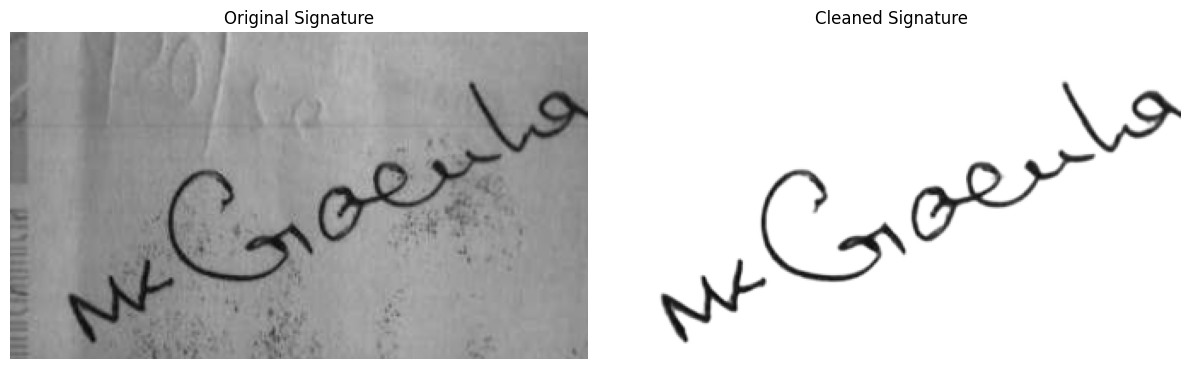

In [24]:
import os
import random

image_path = r'/Users/saurabshrestha/Downloads/cheques/signature/forged_datasets_prep'

# List all image files
all_images = [f for f in os.listdir(image_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly sample 20 images (or fewer if less than 20 available)
sample_images = random.sample(all_images, min(1, len(all_images)))

from PIL import ImageFilter

def save_clean_signature(processed_img: Image.Image, save_path: str, denoise: bool = True):
    white_bg = Image.new("RGB", processed_img.size, (255, 255, 255))
    white_bg.paste(processed_img, mask=processed_img.split()[-1])  # alpha as mask
    if denoise:
        white_bg = white_bg.filter(ImageFilter.MedianFilter(size=3))
    white_bg.save(save_path)

# Process and show each sampled image
for image in sample_images:
    full_path = os.path.join(image_path, image)
    processed_image = demo_single_signature(full_path)
    # save_clean_signature(processed_image, 'test.jpg')



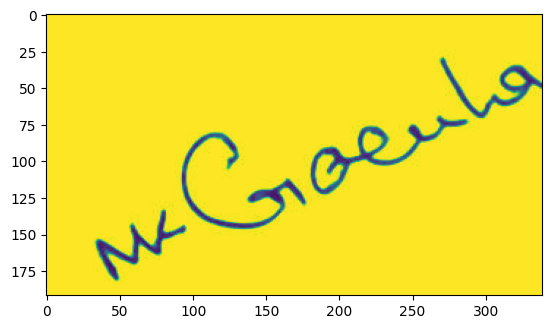

In [28]:
img = 'test.jpg'
img = Image.open(img)
img = img.convert('L')
plt.imshow(img)
plt.show()

Processing single signature: /Users/saurabshrestha/Downloads/cheques/signature/cheques_images/00000011401017500180/2_Signature_2_genuine.png


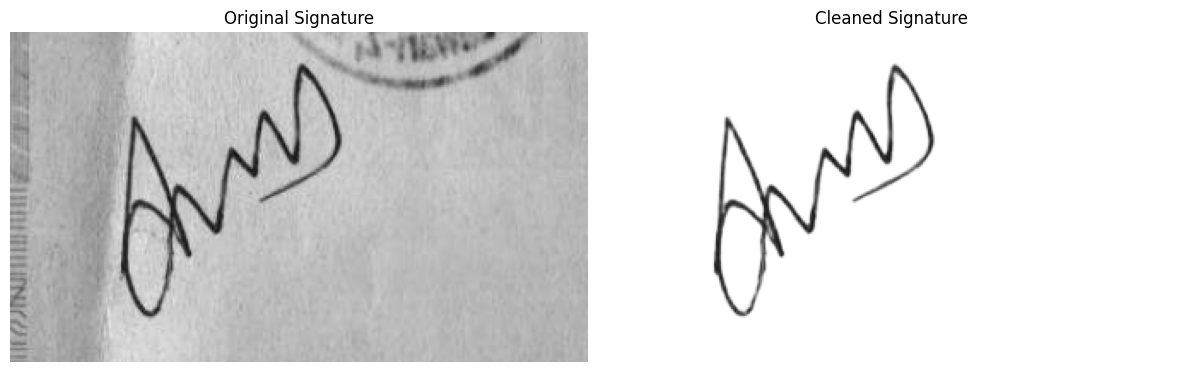

Processing single signature: /Users/saurabshrestha/Downloads/cheques/signature/cheques_images/00000011401017500180/5_Signature_1_genuine.png


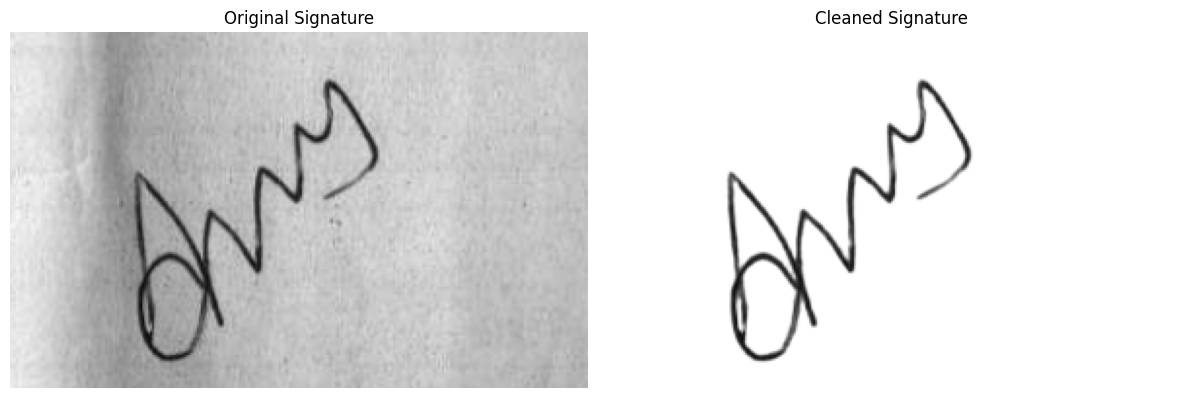

In [42]:
sig_1 = r'/Users/saurabshrestha/Downloads/cheques/signature/cheques_images/00000011401017500180/2_Signature_2_genuine.png'
sig_2 = r'/Users/saurabshrestha/Downloads/cheques/signature/cheques_images/00000011401017500180/5_Signature_1_genuine.png'
processed_image_1 = demo_single_signature(sig_1)
processed_image_2 = demo_single_signature(sig_2)

save_clean_signature(processed_image_1, 'test_1.jpg')
save_clean_signature(processed_image_2, 'test_2.jpg')

In [14]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from core.birefnet_processor import birefnet_processor


def filter_boundary_points(boundary_coords, min_cluster_size=5):
    """Filter boundary points to remove isolated noise"""
    if len(boundary_coords) < min_cluster_size:
        return boundary_coords
    
    points = np.array(boundary_coords)
    filtered_points = []
    processed = set()

    for i, point in enumerate(points):
        if i in processed:
            continue
        distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
        nearby_indices = np.where(distances <= 2)[0]
        if len(nearby_indices) >= min_cluster_size:
            for idx in nearby_indices:
                if idx not in processed:
                    filtered_points.append(tuple(points[idx]))
                    processed.add(idx)

    return filtered_points


def reconstruct_from_boundary_points(boundary_coords, bbox, canvas_shape):
    """Reconstruct image from filtered boundary points"""
    min_x, min_y, max_x, max_y = bbox
    h, w = canvas_shape

    reconstructed = np.zeros((h, w), dtype=np.uint8)
    if len(boundary_coords) == 0:
        return reconstructed

    for x, y in boundary_coords:
        local_x = x - min_x
        local_y = y - min_y
        if 0 <= local_x < w and 0 <= local_y < h:
            reconstructed[local_y, local_x] = 255

    kernel = np.ones((2, 2), np.uint8)
    reconstructed = cv2.dilate(reconstructed, kernel, iterations=1)
    reconstructed = cv2.morphologyEx(reconstructed, cv2.MORPH_CLOSE, kernel, iterations=1)

    return reconstructed


def center_resize(img, target_size=(512, 512)):
    """Resize and center the image on a fixed canvas"""
    h, w = img.shape
    scale = min(target_size[1] / h, target_size[0] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    canvas = np.zeros(target_size, dtype=np.uint8)
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return canvas


def extract_signature_boundary_points(image_path, alpha_thresh=127, min_area=500, padding=10, debug=True):
    """Extract signature from image using BiRefNet and boundary reconstruction"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to PIL for BiRefNet
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    processed_image, _ = birefnet_processor.remove_background(pil_image)

    # Get alpha channel from RGBA
    rgba_np = np.array(processed_image)
    if rgba_np.shape[2] != 4:
        raise ValueError("Expected RGBA image from BiRefNet")

    alpha_mask = rgba_np[:, :, 3]
    mask_binary = (alpha_mask > alpha_thresh).astype(np.uint8) * 255

    # Find valid contours
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("Warning: No contours found in alpha mask.")
        return mask_binary, mask_binary, []

    # Filter or merge contours
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if not contours:
        print("Warning: No significant contours found.")
        return mask_binary, mask_binary, []

    all_pts = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_pts)

    # Apply padding and crop
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(mask_binary.shape[1] - x, w + 2 * padding)
    h = min(mask_binary.shape[0] - y, h + 2 * padding)

    cropped_mask = mask_binary[y:y+h, x:x+w]
    cropped_image = cv2.cvtColor(rgba_np[y:y+h, x:x+w, :3], cv2.COLOR_RGB2GRAY)

    # Debug preview
    if debug:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(mask_binary, cmap='gray')
        plt.title("Alpha Mask")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(cropped_image, cmap='gray')
        plt.title("Cropped Image")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_mask, cmap='gray')
        plt.title("Cropped Mask")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Extract and reconstruct from boundary points
    boundary_points = np.column_stack(np.where(cropped_mask == 255))
    boundary_coords = list(zip(boundary_points[:, 1], boundary_points[:, 0]))

    boundary_coords = filter_boundary_points(boundary_coords, min_cluster_size=5)

    if boundary_coords:
        reconstructed = reconstruct_from_boundary_points(
            boundary_coords,
            bbox=(0, 0, cropped_mask.shape[1], cropped_mask.shape[0]),
            canvas_shape=cropped_mask.shape
        )
    else:
        reconstructed = cropped_mask

    # Optionally normalize output
    reconstructed_resized = center_resize(reconstructed, target_size=(512, 512))

    return cropped_image, reconstructed_resized, boundary_coords


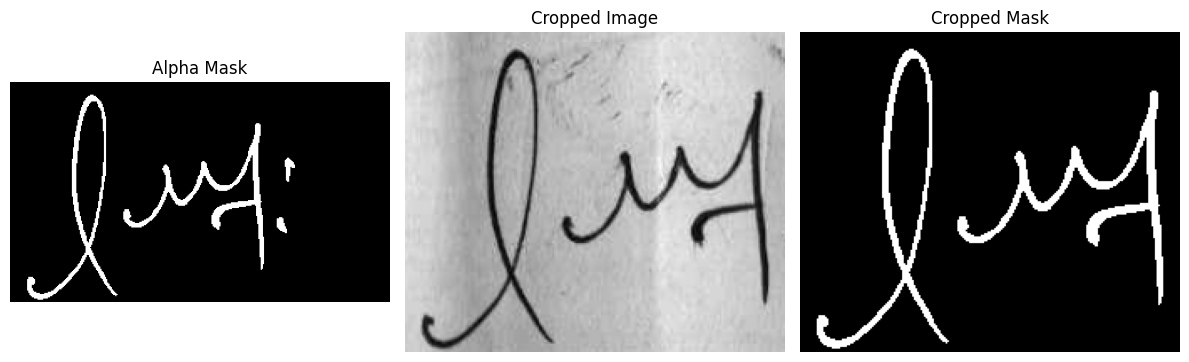

(array([[166, 168, 163, ..., 149, 149, 149],
        [167, 168, 163, ..., 149, 147, 147],
        [167, 168, 163, ..., 149, 144, 144],
        ...,
        [153, 153, 155, ..., 142, 141, 140],
        [152, 151, 155, ..., 143, 146, 144],
        [151, 151, 154, ..., 144, 147, 146]], shape=(191, 227), dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=uint8),
 [(np.int64(65), np.int64(10)),
  (np.int64(66), np.int64(10)),
  (np.int64(67), np.int64(10)),
  (np.int64(64), np.int64(11)),
  (np.int64(65), np.int64(11)),
  (np.int64(66), np.int64(11)),
  (np.int64(65), np.int64(12)),
  (np.int64(63), np.int64(11)),
  (np.int64(62), np.int64(12)),
  (np.int64(63), np.int64(12)),
  (np.int64(64), np.int64(12)),
  (np.int64(63), np.int64(13)),
  (np.int64(67), np.int64(11)),
  (np.int64(68), np.int6

In [16]:
file_path = r'/Users/saurabshrestha/Downloads/cheques/signature/forged_datasets_prep/00000005101017501168_1_Signature_1_genuine.png'
extract_signature_boundary_points(file_path)

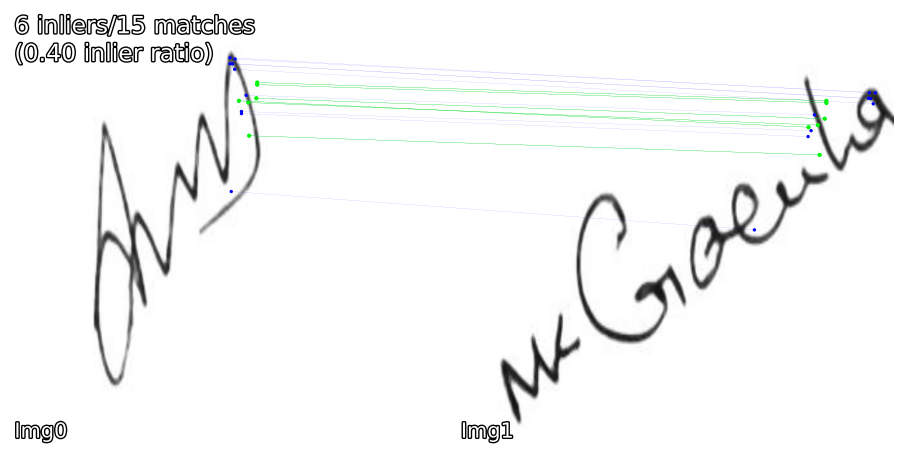

In [59]:
from matching import get_matcher
from matching.viz import plot_matches

device = 'cpu'  # 'cpu'
matcher = get_matcher('superpoint-lg', device=device) 
img_size = 512  # optional

img0 = matcher.load_image('test_1.jpg', resize=img_size)
img1 = matcher.load_image('test.jpg', resize=img_size)

result = matcher(img0, img1)
num_inliers, H, inlier_kpts0, inlier_kpts1 = result['num_inliers'], result['H'], result['inlier_kpts0'], result['inlier_kpts1']
# result.keys() = ['num_inliers', 'H', 'all_kpts0', 'all_kpts1', 'all_desc0', 'all_desc1', 'matched_kpts0', 'matched_kpts1', 'inlier_kpts0', 'inlier_kpts1']
plot_matches(img0, img1, result, save_path='plot_matches.png')

In [ ]:
from typing import Tuple

from scipy import ndimage


class SignatureCleaner:
    def __init__(self, device: str = None):
        """
        Initialize SignatureCleaner by loading the BiRefNet model.
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading BiRefNet model...")
        self.model = AutoModelForImageSegmentation.from_pretrained(
            "ZhengPeng7/BiRefNet", trust_remote_code=True
        )
        self.model.to(self.device)
        self.model.eval()
        print("Model loaded successfully!")

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def load_image(self, image_input: Union[str, Image.Image]) -> Image.Image:
        """
        Load an image from path, URL, or PIL object.
        """
        if isinstance(image_input, Image.Image):
            return image_input.convert("RGB")
        elif isinstance(image_input, str):
            if image_input.startswith(('http://', 'https://')):
                response = requests.get(image_input)
                image = Image.open(BytesIO(response.content))
            else:
                image = Image.open(image_input)
            return image.convert("RGB")
        else:
            raise ValueError("Image must be a file path, URL, or PIL Image object")

    def clean_image(self, image: Union[str, Image.Image], with_alpha: bool = False) -> Tuple[Image.Image, np.ndarray]:
        """
        Remove background using BiRefNet and return cleaned image.

        Args:
            image (str or PIL.Image): Input image path or object.
            with_alpha (bool): If True, return image with alpha (RGBA). Default is False (RGB).

        Returns:
            Tuple[Image.Image, np.ndarray]: Cleaned image and binary mask.
        """
        image = self.load_image(image)
        original_size = image.size
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            prediction = self.model(input_tensor)[-1].sigmoid().cpu()

        mask = prediction[0].squeeze()
        mask_pil = transforms.ToPILImage()(mask)
        mask_resized = mask_pil.resize(original_size)

        if with_alpha:
            # Add alpha channel to original image
            result_image = image.copy().convert("RGBA")
            result_image.putalpha(mask_resized)
        else:
            # Composite over white background to get RGB
            image_rgb = image.convert('RGB')
            background = Image.new('RGB', image.size, (255, 255, 255))
            alpha_mask = mask_resized.convert("L")
            result_image = Image.composite(image_rgb, background, alpha_mask)

        return result_image, np.array(mask_resized)

    def normalize_image(self, img: np.ndarray, size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
        """
        Normalize image size and position with dynamic canvas sizing.
        
        Args:
            img (np.ndarray): Input image as numpy array
            size (Tuple[int, int]): Maximum allowed size (height, width)
        
        Returns:
            np.ndarray: Normalized image
        """
        max_r_limit, max_c_limit = size

        # Apply gaussian filter to remove small components
        blur_radius = 0
        blurred_image = ndimage.gaussian_filter(img, blur_radius)

        # Binarize the image using OTSU's algorithm
        if blurred_image.dtype != np.uint8:
            blurred_image = (blurred_image / blurred_image.max() * 255).astype(np.uint8)

        threshold, binarized_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find the center of mass of the foreground pixels
        r, c = np.where(binarized_image == 0)

        # If no foreground pixels found, return blank canvas
        if r.size == 0 or c.size == 0:
            print("Warning: No foreground pixels found. Returning a blank canvas of max size.")
            return np.ones(size, dtype=np.uint8) * 255

        r_center = int(r.mean() - r.min())
        c_center = int(c.mean() - c.min())

        # Crop the image with tight bounding box
        cropped = img[r.min(): r.max(), c.min(): c.max()]

        # Dynamically determine output canvas size
        img_r, img_c = cropped.shape
        border_padding = 80

        # Calculate desired canvas size
        desired_r = min(max_r_limit, img_r + 2 * border_padding)
        desired_c = min(max_c_limit, img_c + 2 * border_padding)

        # Calculate starting positions to center the image
        r_start = (desired_r // 2) - r_center
        c_start = (desired_c // 2) - c_center

        # Adjust start positions to ensure they fit
        if r_start < 0:
            r_start = 0
        elif r_start + img_r > desired_r:
            r_start = desired_r - img_r
            if r_start < 0:
                r_start = 0
                if img_r > desired_r:
                    print(f"Warning: Image height ({img_r}) exceeds desired canvas height ({desired_r}). Content may be cropped.")
                    cropped = cropped[:desired_r, :]
                    img_r = desired_r

        if c_start < 0:
            c_start = 0
        elif c_start + img_c > desired_c:
            c_start = desired_c - img_c
            if c_start < 0:
                c_start = 0
                if img_c > desired_c:
                    print(f"Warning: Image width ({img_c}) exceeds desired canvas width ({desired_c}). Content may be cropped.")
                    cropped = cropped[:, :desired_c]
                    img_c = desired_c

        # Create normalized image with dynamic size
        normalized_image = np.ones((desired_r, desired_c), dtype=np.uint8) * 255

        # Add cropped and centered image to canvas
        normalized_image[r_start:r_start + img_r, c_start:c_start + img_c] = cropped

        # Remove noise - pixels above threshold set to white
        normalized_image[normalized_image > threshold] = 255

        return normalized_image

    def save_image(self, image: Image.Image, save_path: str):
        """
        Save the cleaned image to the given path.
        """
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # If the image has an alpha channel, flatten it
        if image.mode == 'RGBA':
            background = Image.new('RGB', image.size, (255, 255, 255))
            image = Image.alpha_composite(background.convert('RGBA'), image).convert('RGB')

        # Save the image
        image.save(save_path)
        print(f"Saved cleaned image to: {save_path}")

    

In [6]:
import os
import json

def convert_to_absolute_paths(ann_dir, img_dir, output_path, url_format="local"):
    """
    Convert annotations to Label Studio format
    
    Args:
        url_format: "local", "file", or "relative"
            - "local": /data/local-files/?d=path (for Label Studio local serving)
            - "file": file://path (absolute file paths)
            - "relative": just the relative path (for web serving)
    """
    output = []
    img_dir_abs = os.path.abspath(img_dir)
    
    for fname in os.listdir(ann_dir):
        if not fname.endswith('.json'):
            continue
        
        # Remove .json extension to get the image filename
        # e.g., "nist_r0647_01.png.json" -> "nist_r0647_01.png"
        image_name = fname[:-5]  # Remove ".json"
        
        # Check if this image file exists
        if not os.path.exists(os.path.join(img_dir_abs, image_name)):
            print(f"[!] Image file not found for annotation: {fname}")
            print(f"    Expected: {os.path.join(img_dir_abs, image_name)}")
            continue
        
        image_path = os.path.join(img_dir_abs, image_name)
        
        # Generate appropriate URL based on format
        if url_format == "local":
            # For Label Studio local serving - use relative path from current directory
            rel_path = os.path.relpath(image_path).replace('\\', '/')
            image_url = f"/data/local-files/?d={rel_path}"
        elif url_format == "file":
            # Absolute file path
            image_url = f"file://{image_path}"
        elif url_format == "absolute_local":
            # Absolute path for local serving (your approach)
            image_url = f"/data/local-files/?d={image_path}"
        else:  # relative
            rel_path = os.path.relpath(image_path).replace('\\', '/')
            image_url = rel_path
        
        # Load annotation
        with open(os.path.join(ann_dir, fname), 'r') as f:
            ann = json.load(f)
        
        img_w = ann['size']['width']
        img_h = ann['size']['height']
        
        results = []
        for obj in ann['objects']:
            if obj['geometryType'] != 'rectangle':
                continue
                
            (x0, y0), (x1, y1) = obj['points']['exterior']
            bbox_w = x1 - x0
            bbox_h = y1 - y0
            
            # Convert to percentage coordinates
            x = x0 / img_w * 100
            y = y0 / img_h * 100
            w = bbox_w / img_w * 100
            h = bbox_h / img_h * 100
            
            results.append({
                "from_name": "label",
                "to_name": "image",
                "type": "rectanglelabels",
                "value": {
                    "x": x, "y": y, "width": w, "height": h,
                    "rectanglelabels": [obj['classTitle']]
                }
            })
        
        output.append({
            "data": {
                "image": image_url
            },
            "annotations": [{
                "result": results
            }]
        })
    
    # Save to output file
    with open(output_path, "w") as f:
        json.dump(output, f, indent=2)
    
    print(f"✅ Exported {len(output)} tasks to {output_path}")
    print(f"   Using URL format: {url_format}")
    if url_format in ["local", "absolute_local"]:
        print("   Make sure to start Label Studio with: --local-files-serving-enabled")

def debug_file_structure(dataset_root):
    """
    Debug function to check file naming patterns
    """
    print("=== DEBUGGING FILE STRUCTURE ===")
    
    for split in ["train", "test"]:
        ann_dir = os.path.join(dataset_root, split, "ann")
        img_dir = os.path.join(dataset_root, split, "img")
        
        if not os.path.exists(ann_dir) or not os.path.exists(img_dir):
            continue
            
        print(f"\n{split.upper()} SET:")
        print(f"Annotation dir: {ann_dir}")
        print(f"Image dir: {img_dir}")
        
        # List first 5 annotation files
        ann_files = [f for f in os.listdir(ann_dir) if f.endswith('.json')]
        print(f"Sample annotation files ({len(ann_files)} total):")
        for f in ann_files[:5]:
            print(f"  {f}")
        
        # List first 5 image files
        img_files = os.listdir(img_dir)
        print(f"Sample image files ({len(img_files)} total):")
        for f in img_files[:5]:
            print(f"  {f}")
        
        # Check naming pattern
        print("File matching check:")
        for ann_file in ann_files[:3]:
            expected_img = ann_file[:-5]  # Remove .json
            img_exists = os.path.exists(os.path.join(img_dir, expected_img))
            print(f"  {ann_file} -> {expected_img} : {'✅' if img_exists else '❌'}")

def process_dataset(dataset_root, url_format="local"):
    """
    Process both train and test datasets
    
    Args:
        url_format: "local", "file", "absolute_local", or "relative"
    """
    # Debug first
    debug_file_structure(dataset_root)
    print("\n" + "="*50)
    
    # Process training data
    train_ann_dir = os.path.join(dataset_root, "train", "ann")
    train_img_dir = os.path.join(dataset_root, "train", "img")
    train_output = os.path.join(dataset_root, "train_labels.json")
    
    if os.path.exists(train_ann_dir) and os.path.exists(train_img_dir):
        print("Processing training data...")
        convert_to_absolute_paths(train_ann_dir, train_img_dir, train_output, url_format)
    else:
        print("Training directories not found!")
    
    # Process test data
    test_ann_dir = os.path.join(dataset_root, "test", "ann")
    test_img_dir = os.path.join(dataset_root, "test", "img")
    test_output = os.path.join(dataset_root, "test_labels.json")
    
    if os.path.exists(test_ann_dir) and os.path.exists(test_img_dir):
        print("Processing test data...")
        convert_to_absolute_paths(test_ann_dir, test_img_dir, test_output, url_format)
    else:
        print("Test directories not found!")

# Usage examples:
if __name__ == "__main__":
    dataset_root = "."  # or provide full path
    
    # Try different URL formats based on what works with your Label Studio setup:
    
    # Option 1: Relative paths (recommended first try)
    process_dataset(dataset_root, url_format="local")
    
    # Option 2: Absolute paths for local serving (if relative doesn't work)
    # process_dataset(dataset_root, url_format="absolute_local")
    
    # Option 3: File protocol (fallback)
    # process_dataset(dataset_root, url_format="file")

# Individual processing examples:
# convert_to_absolute_paths("train/ann", "train/img", "train_labels.json", "local")
# convert_to_absolute_paths("test/ann", "test/img", "test_labels.json", "absolute_local")

=== DEBUGGING FILE STRUCTURE ===

Training directories not found!
Test directories not found!


In [8]:
process_dataset(".", url_format="file")

=== DEBUGGING FILE STRUCTURE ===

Training directories not found!
Test directories not found!


In [7]:
# # Example usage
# convert_to_absolute_paths(
#     img_dir="/Users/saurabshrestha/Documents/SignatureVerification/Signature_detection_datasets/eyJsaW5rIjogImZzOi8vYXNzZXRzLzI5MTRfU2lnbnZlck9EL3NpZ252ZXJvZC1EYXRhc2V0TmluamEudGFyIiwgInNpZyI6ICJHb3MzWmk5OGlYeGtmbXhMQWMrelF5L0VPdUM1RGVZdzJCNmVLaGV3c0hNPSJ9/test/img",
#     ann_dir="/Users/saurabshrestha/Documents/SignatureVerification/Signature_detection_datasets/eyJsaW5rIjogImZzOi8vYXNzZXRzLzI5MTRfU2lnbnZlck9EL3NpZ252ZXJvZC1EYXRhc2V0TmluamEudGFyIiwgInNpZyI6ICJHb3MzWmk5OGlYeGtmbXhMQWMrelF5L0VPdUM1RGVZdzJCNmVLaGV3c0hNPSJ9/test/ann",
#     output_path="labelstudio_import_test.json",
# )

dataset_root = f"/Users/saurabshrestha/Documents/SignatureVerification/Signature_detection_datasets/eyJsaW5rIjogImZzOi8vYXNzZXRzLzI5MTRfU2lnbnZlck9EL3NpZ252ZXJvZC1EYXRhc2V0TmluamEudGFyIiwgInNpZyI6ICJHb3MzWmk5OGlYeGtmbXhMQWMrelF5L0VPdUM1RGVZdzJCNmVLaGV3c0hNPSJ9/"
process_dataset(dataset_root)

=== DEBUGGING FILE STRUCTURE ===

TRAIN SET:
Annotation dir: /Users/saurabshrestha/Documents/SignatureVerification/Signature_detection_datasets/eyJsaW5rIjogImZzOi8vYXNzZXRzLzI5MTRfU2lnbnZlck9EL3NpZ252ZXJvZC1EYXRhc2V0TmluamEudGFyIiwgInNpZyI6ICJHb3MzWmk5OGlYeGtmbXhMQWMrelF5L0VPdUM1RGVZdzJCNmVLaGV3c0hNPSJ9/train/ann
Image dir: /Users/saurabshrestha/Documents/SignatureVerification/Signature_detection_datasets/eyJsaW5rIjogImZzOi8vYXNzZXRzLzI5MTRfU2lnbnZlck9EL3NpZ252ZXJvZC1EYXRhc2V0TmluamEudGFyIiwgInNpZyI6ICJHb3MzWmk5OGlYeGtmbXhMQWMrelF5L0VPdUM1RGVZdzJCNmVLaGV3c0hNPSJ9/train/img
Sample annotation files (2565 total):
  nist_r0647_01.png.json
  gsa_LAK07213-SLA-5-_Z-01.png.json
  dwr29e00_2.png.json
  nist_r0288_01.png.json
  gsa_LAL62317-SLA-1-_Z-01.png.json
Sample image files (2565 total):
  gsa_LAZ01910-SLA-14-_Z-01.png
  gsa_LAR17002-SLA-4_-_Z-01.png
  gsa_LAZ02343-Lease_Z-01.png
  djy33f00-page02_2.png
  gsa_Download Documents - Executed Lease LNC60480_Redacted-01.png
File matching check: